In [1]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("harishkumardatalab/food-image-classification-dataset")

print("Path to dataset files:", dataset_path)

100%|██████████| 1.68G/1.68G [00:13<00:00, 130MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/harishkumardatalab/food-image-classification-dataset/versions/1


In [6]:
import os
import shutil

categories = ["burger", "Taco", "cheesecake", "Sandwich","pizza"]

# Make custom dataset folder
output_path = "my_food_dataset"
os.makedirs(output_path, exist_ok=True)

# Copy only selected categories
for category in categories:
    src = os.path.join(dataset_path + "/Food Classification dataset/", category)
    dst = os.path.join(output_path, category)
    if os.path.exists(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
        print(f"✅ Copied {category}")
    else:
        print(f"⚠️ Category {category} not found!")

/root/.cache/kagglehub/datasets/harishkumardatalab/food-image-classification-dataset/versions/1/Food Classification dataset/burger
my_food_dataset/burger
✅ Copied burger
/root/.cache/kagglehub/datasets/harishkumardatalab/food-image-classification-dataset/versions/1/Food Classification dataset/Taco
my_food_dataset/Taco
✅ Copied Taco
/root/.cache/kagglehub/datasets/harishkumardatalab/food-image-classification-dataset/versions/1/Food Classification dataset/cheesecake
my_food_dataset/cheesecake
✅ Copied cheesecake
/root/.cache/kagglehub/datasets/harishkumardatalab/food-image-classification-dataset/versions/1/Food Classification dataset/Sandwich
my_food_dataset/Sandwich
✅ Copied Sandwich
/root/.cache/kagglehub/datasets/harishkumardatalab/food-image-classification-dataset/versions/1/Food Classification dataset/pizza
my_food_dataset/pizza
✅ Copied pizza


In [7]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [9]:
#Count number of images for each food category
count = 0
dirs = os.listdir('my_food_dataset/')
for dir in dirs:
    files = list(os.listdir('my_food_dataset/'+dir))
    print( dir +' folder has '+ str(len(files)) + ' Images')
    count = count + len(files)
print( 'my_food_dataset folder has '+ str(count) + ' Images')

burger folder has 331 Images
cheesecake folder has 1000 Images
Taco folder has 1500 Images
Sandwich folder has 1500 Images
pizza folder has 275 Images
my_food_dataset folder has 4606 Images


In [24]:
#Load Images into Arrays

base_dir = 'my_food_dataset/'
img_size = 180 #180x180 pixels
batch = 32

train_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4606 files belonging to 5 classes.
Using 3685 files for training.
Found 4606 files belonging to 5 classes.
Using 921 files for validation.


In [25]:
classes = train_ds.class_names
classes

['burger', 'cheesecake', 'pizza', 'sandwich', 'taco']

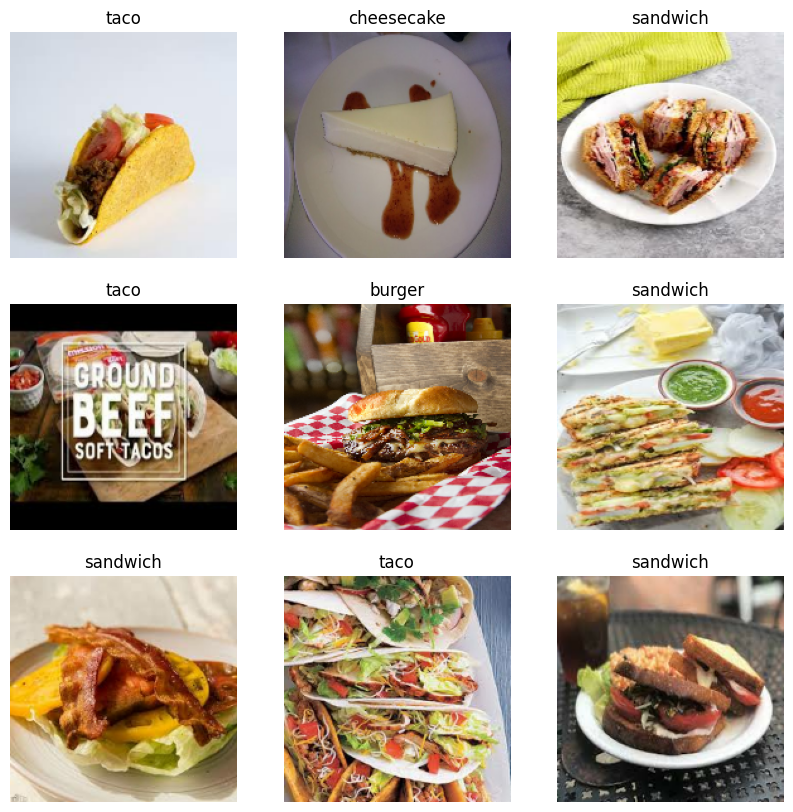

In [26]:
import matplotlib.pyplot as plt
i = 0
plt.figure(figsize=(10,10))

#take 1 batch from the dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classes[labels[i]])
        plt.axis('off')

In [27]:
#Place dataset images in cache for faster training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


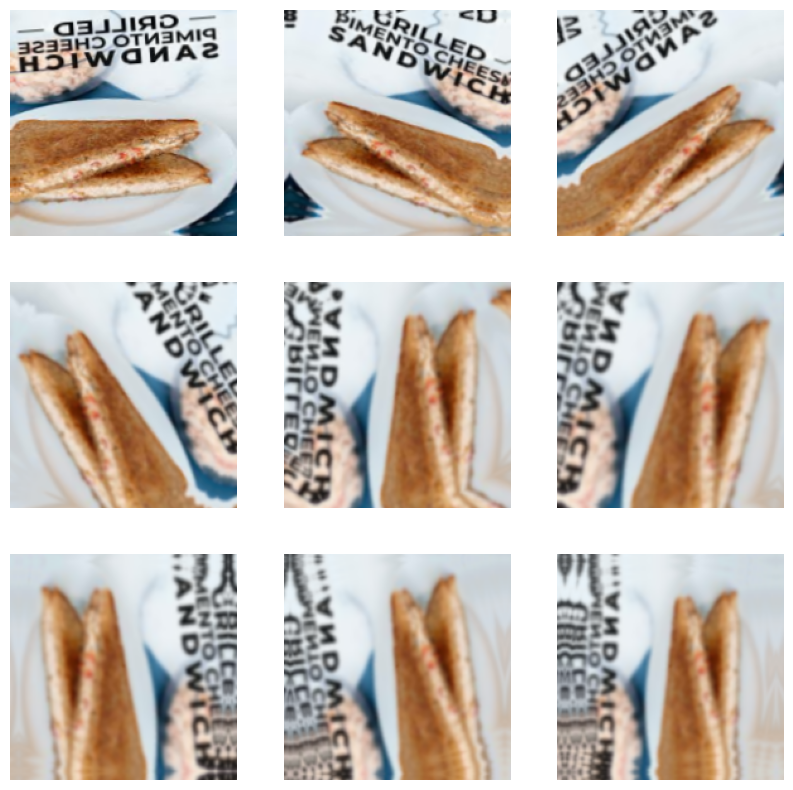

In [55]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [56]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255), #from 0,255 -> 0,1
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 104s 885ms/step - accuracy: 0.3412 - loss: 1.5186 - val_accuracy: 0.5353 - val_loss: 1.1173
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 137s 840ms/step - accuracy: 0.5087 - loss: 1.1471 - val_accuracy: 0.5353 - val_loss: 1.1423
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 97s 841ms/step - accuracy: 0.6077 - loss: 0.9794 - val_accuracy: 0.6015 - val_loss: 1.0168
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 100s 863ms/step - accuracy: 0.6475 - loss: 0.8948 - val_accuracy: 0.6276 - val_loss: 0.9669
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 142s 862ms/step - accuracy: 0.6611 - loss: 0.8538 - val_accuracy: 0.6428 - val_loss: 0.9409
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 98s 845ms/step - accuracy: 0.6891 - loss: 0.7932 - val_accuracy: 0.6037 - val_loss: 1.0586
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 98s 845ms/step - accuracy: 0.7108 - loss: 0.7475 - val_accuracy: 0.6232 - val_loss: 1.0204
Epoch 8/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 97s 841ms/step - accuracy: 0.7229 - los

In [105]:
def classify_and_plot(img_path):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for i, ax in enumerate(axes.flat):
        # Load and preprocess
        input_image = tf.keras.utils.load_img(img_path[i], target_size=(180,180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        # Predict
        predictions = model.predict(input_image_exp_dim, verbose=0)
        result = tf.nn.softmax(predictions[0])
        pred_class = classes[np.argmax(result)]
        score = np.max(result) * 100

        # Show image
        ax.imshow(input_image_array.astype("uint8"))
        ax.axis("off")
        ax.set_title(f"{pred_class} ({score:.1f}%)", fontsize=10)

    plt.suptitle("Model Predictions on Test Images", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

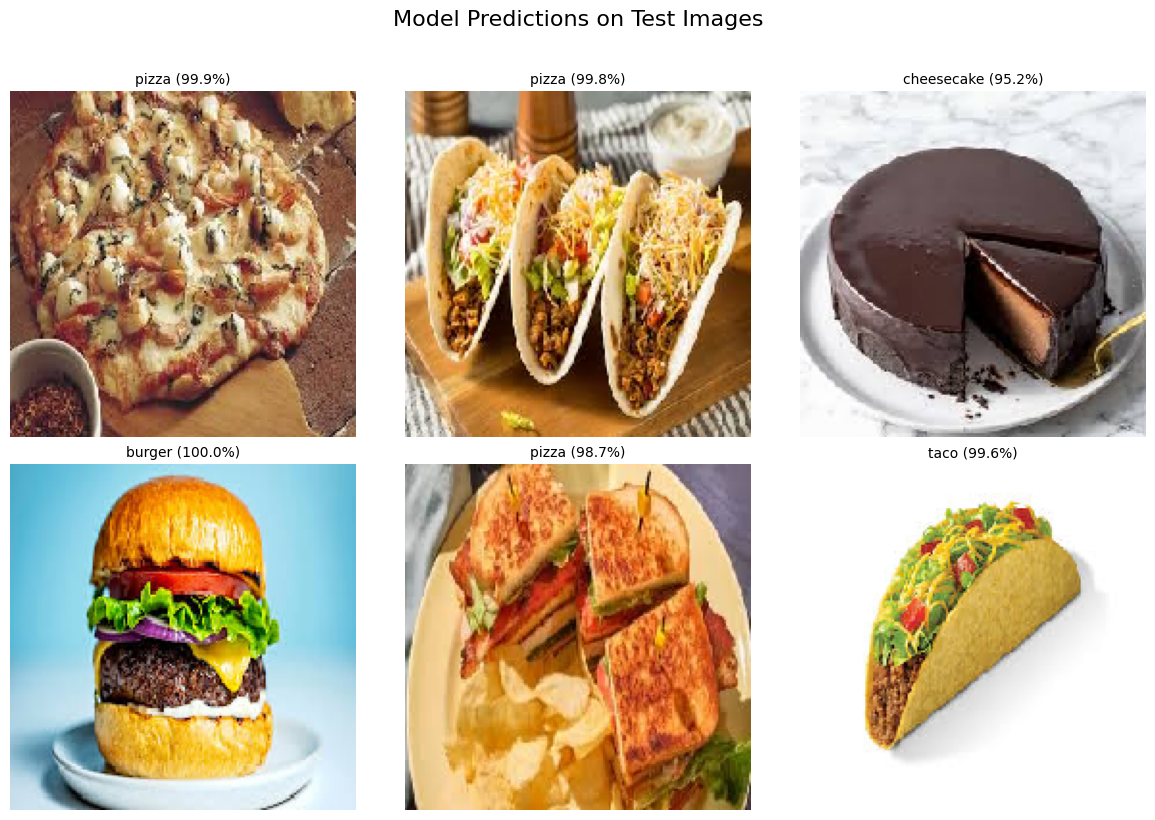

In [106]:
import glob
test_images = glob.glob("food_dataset_test_data/*.jpeg")
classify_and_plot(test_images)